# imports

In [45]:
from sentence_transformers import SentenceTransformer, util
import torch
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel, AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TextClassificationPipeline, DataCollatorWithPadding

import sqlite3
import argparse
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import os
from numpy.linalg import norm
import sys
from itertools import combinations
import random
from sklearn.model_selection import train_test_split

from datasets import load_dataset

# Utils

In [2]:
class UnionFind:
    def __init__(self):
        self.parent = {}  # Dictionary to store parent nodes
        self.ranks = {}    # Dictionary to store rank (or size) of each set
        self.processed = False
        self.project_name = None

    def find(self, x):
        if x not in self.parent:
            self.parent[x] = x
            self.ranks[x] = 1
            return x

        # Path compression
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]

    def union(self, x, y):
        root_x = self.find(x)
        root_y = self.find(y)

        if root_x != root_y:
            if self.ranks[root_x] < self.ranks[root_y]:
                self.parent[root_x] = root_y
                self.ranks[root_y] += self.ranks[root_x]
            else:
                self.parent[root_y] = root_x
                self.ranks[root_x] += self.ranks[root_y]
            
    def process_project(self, conn, project_name):
        cursor = conn.cursor()
        self.project_name = project_name
        
        cursor.execute(f"SELECT * FROM {project_name}")
        for row in cursor.fetchall():
            dup_id = int(row[column_names.index("dup_id")])
            if dup_id == -1: continue
            bug_id = int(row[column_names.index("bug_id")])
            if (dup_id == bug_id): continue
            assert(dup_id != bug_id)
            self.union(bug_id, dup_id)
        self.processed = True
            
    def get_roots(self,):
        assert(self.processed)
        return list(set(self.parent.values()))
    
    def get_children(self, parent):
        assert(self.processed)
        parent = self.find(parent)
        children = [key for key, value in self.parent.items() if value == parent]
        return children
    
    def get_all_children(self, ):
        return [key for key, value in self.parent.items()]
    
    def are_dups(this, bug_id1, bug_id2):
        if (bug_id1 not in this.parent.keys() or bug_id2 not in this.parent.keys()):
            return False
        return this.parent[bug_id1] == this.parent[bug_id2]
            

In [3]:
def get_bug_ids(conn, table_name):
    cursor = conn.cursor()
    column_name = "bug_id"

    # Fetch table names using SQL query
    cursor.execute(f"SELECT DISTINCT {column_name} FROM {table_name} ORDER BY {column_name};")
    distinct_values_sorted = cursor.fetchall()

    # Extract table names from the result
    return [value[0] for value in distinct_values_sorted]

In [4]:
def get_column_names(conn, table_name):
    cursor = conn.cursor()

    # Execute a query to get information about the columns in the specified table
    cursor.execute(f"PRAGMA table_info({table_name});")
    columns_info = cursor.fetchall()

    # Extract and return the column names
    column_names = [column[1] for column in columns_info]
    return column_names

In [5]:
def get_code_feature(conn, project_name, bug_id):
    cursor = conn.cursor()

    # Fetch table names using SQL query
    query = f"SELECT * FROM {project_name} WHERE bug_id = {bug_id};"
    # print(query)
    cursor.execute(query)
    result = cursor.fetchall()[0]
    return result[column_names.index("code_feature")]

In [6]:
def get_descriptions(conn, project_name, bug_id):
    cursor = conn.cursor()

    # Fetch table names using SQL query
    query = f"SELECT * FROM {project_name} WHERE bug_id = {bug_id};"
    # print(query)
    cursor.execute(query)
    result = cursor.fetchall()[0]
    desc = result[column_names.index("description")]
    short_desc = result[column_names.index("short_desc")]

    # Extract table names from the result
    return (desc + " \n " + short_desc).replace("\\'", "'")

In [7]:
def get_text_feature_from_db(conn, project_name, bug_id, selected_columns):
    cursor = conn.cursor()

    # Fetch table names using SQL query
    query = f"SELECT * FROM {project_name} WHERE bug_id = {bug_id};"
    # print(query)
    cursor.execute(query)
    result = cursor.fetchall()[0]
    ret = ""
    for selected_column in selected_columns:
        ret += result[column_names.index(selected_columns)] + " "

    # Extract table names from the result
    return ret.replace("\\'", "'")

In [8]:
def vectorize(description, stride_len, chunk_size):
    tokens = tokenizer.tokenize(description)
    # if len og token array is < 32, we do nothing as there is not enough information
    if (len(tokens) < chunk_size // 2): return None

    # remember to add cls and sep token at each chunk
    token_ids = tokenizer.convert_tokens_to_ids([tokenizer.cls_token]+tokens+[tokenizer.sep_token])

    # divide token ids into batche of chunks
    chunk_list=[]
    for i in range(0, len(token_ids), stride_len):
        chunk = token_ids[i:min(i+chunk_size, len(token_ids))]
        assert(len(chunk) <= chunk_size)
        if len(chunk) < chunk_size:
            # keep going
            continue
            # if (len(chunk) < chunk_size // 2): continue
            # pad_length = chunk_size - len(chunk)
            # chunk += [tokenizer.pad_token_id]*pad_length
        assert(len(chunk) == chunk_size)
        # print(chunk)
        chunk_list.append(chunk)

    if(len(chunk_list) == 0): return None
    chunk_arr = np.array(chunk_list)
    # print("Chunk arr size{}".format(chunk_arr.shape))
    # context_embedding = model(torch.tensor(token_ids[:512])[None, :])[0]
    context_embedding = model(torch.tensor(chunk_arr)[:, :])[0]
    return context_embedding.detach().numpy()

In [9]:
def get_duplicated_pairs(union_find):
    roots = union_find.get_roots()
    pairs = []
    for root in roots:
        group = union_find.get_children(root)
        pairs += list(combinations(group, 2))
    return pairs

In [10]:
def get_non_duplicated_pairs(union_find, conn, size):
    from_dup = union_find.get_all_children()
    #sample in some other single reports
    assert(union_find.processed)
    samples = random.sample(get_bug_ids(conn, union_find.project_name), len(from_dup))
    
    pairs = []
    count = 0
    while (count < size):
        pair = random.sample(samples, 2)
        if pair[0] == pair[1] or union_find.are_dups(pair[0], pair[1]):
            continue
        pairs += [(pair[0], pair[1]),]
        count += 1
    return pairs

In [11]:
def get_mislabels(union_find, bug_ids, anchor_bug_id, threshold):
    assert(threshold >= 0 and threshold <= 1)
    ret = []
    for bug_id in tqdm(bug_ids):
        if not union_find.are_dups(anchor_bug_id, bug_id):
            sim_score = get_similarity_of_pair((anchor_bug_id, bug_id),)
            if sim_score > threshold:
                ret += [bug_id]
    return ret

In [46]:
def preprocess_function(examples):
        # Tokenize the texts
        args = (
            (examples[sentence1_key],) if sentence2_key is None else (examples[sentence1_key], examples[sentence2_key])
        )
        result = tokenizer(*args, padding=padding, max_length=max_seq_length, truncation=True)

        # Map labels to IDs (not necessary for GLUE tasks)
        if label_to_id is not None and "label" in examples:
            result["label"] = [(label_to_id[l] if l != -1 else -1) for l in examples["label"]]
        return result

# Connect to the database

In [14]:
database_path = "./dbrd_w_tech_terms.db"


conn = sqlite3.connect(database_path)
cursor = conn.cursor()

## Structuring our dataset

In [61]:
project_name = "eclipse"

bug_ids = get_bug_ids(conn, project_name)

column_names = get_column_names(conn, project_name)

union_find = UnionFind()
union_find.process_project(conn, project_name)

In [62]:
positive_set = get_duplicated_pairs(union_find)
positive_labels = [1]*len(positive_set)

In [63]:
negative_set = get_non_duplicated_pairs(union_find, conn, len(positive_set)*3)
negative_labels = [0]*len(negative_set)

In [64]:
print(len(positive_set), len(negative_set))

2792 8376


Out training set is 80% of positive set and 80% of negative set

In [70]:
X_train, X_test, y_train, y_test = train_test_split(positive_set+negative_set, positive_labels+negative_labels, test_size=0.2, random_state=42)

In [71]:
y_train.count(1)

2230

In [72]:
len(y_train)

8934

In [73]:
y_test.count(1)

562

In [74]:
len(y_test)

2234

# getting model

In [25]:
model_path = "/home/grads/t/tiendat.ng.cs/github_repos/RepresentThemALL/dupbrdet/openoffice_results"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer)

In [32]:
raw_datasets = load_dataset("csv", data_files="./datasets/dup_br_data/hadoop_old_train.csv")

Extracting data files: 100%|██████████| 1/1 [00:00<00:00, 944.45it/s]
Generating train split: 2406 examples [00:00, 31549.63 examples/s]


In [48]:
processed_raw_datasets = raw_datasets.map(
        preprocess_function,
        batched=True,
        desc="Running tokenizer on dataset",
    )

Running tokenizer on dataset:   0%|          | 0/2406 [00:00<?, ? examples/s]


NameError: name 'sentence2_key' is not defined

In [44]:
classifier(raw_datasets["train"][0]["bug1"] + raw_datasets["train"][0]["bug2"])

[{'label': 'yes', 'score': 0.9999542236328125}]

## Hadoop

In [15]:
project_name = "hadoop"

bug_ids = get_bug_ids(conn, project_name)

column_names = get_column_names(conn, project_name)

union_find = UnionFind()
union_find.process_project(conn, project_name)

In [16]:
positive_set = get_duplicated_pairs(union_find)

In [17]:
negative_set = get_non_duplicated_pairs(union_find, conn, len(positive_set)*5)

In [18]:
len(positive_set)

431

In [19]:
len(negative_set)

2155

In [ ]:
sim_scores_pos = np.array([get_similarity_of_pair_with_code_feature(pair) for pair in positive_set])

NameError: name 'get_similarity_of_pair_with_code_feature' is not defined

In [ ]:
sim_scores_neg = np.array([get_similarity_of_pair_with_code_feature(pair) for pair in negative_set])

In [ ]:
print(sim_scores_pos.mean(), sim_scores_pos.std())
print(sim_scores_neg.mean(), sim_scores_neg.std())

0.57726604 0.25344652
0.16706899 0.13918407


(array([ 5.,  1.,  6.,  7.,  5.,  7.,  6.,  6., 10., 13., 19., 14., 13.,
        15., 17., 22., 12., 28., 23., 23., 14., 28., 18., 16., 28., 16.,
        16.,  7.,  8., 28.]),
 array([-0.04722407, -0.0123166 ,  0.02259088,  0.05749836,  0.09240583,
         0.12731332,  0.16222079,  0.19712827,  0.23203574,  0.26694322,
         0.30185071,  0.33675817,  0.37166566,  0.40657312,  0.44148061,
         0.4763881 ,  0.51129556,  0.54620302,  0.58111054,  0.616018  ,
         0.65092546,  0.68583292,  0.72074044,  0.7556479 ,  0.79055536,
         0.82546288,  0.86037034,  0.8952778 ,  0.93018526,  0.96509278,
         1.00000024]),
 <BarContainer object of 30 artists>)

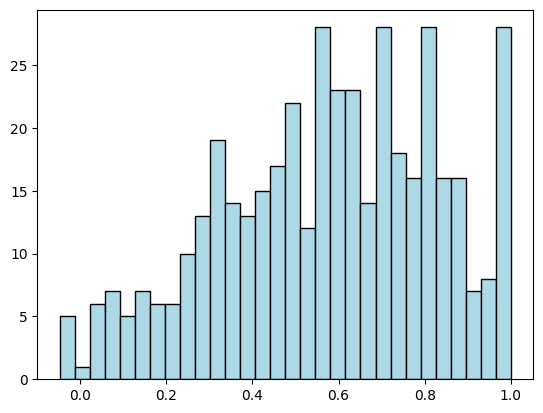

In [ ]:
plt.hist(sim_scores_pos, color='lightblue', ec='black', bins=30)

(array([  1.,   6.,  32.,  49., 112., 160., 199., 238., 216., 232., 159.,
        168., 126., 108.,  80.,  65.,  37.,  49.,  41.,  26.,  16.,   9.,
         15.,   4.,   2.,   2.,   0.,   2.,   0.,   1.]),
 array([-0.15785135, -0.1252148 , -0.09257824, -0.05994168, -0.02730512,
         0.00533143,  0.03796799,  0.07060455,  0.10324111,  0.13587767,
         0.16851422,  0.20115077,  0.23378734,  0.26642388,  0.29906046,
         0.33169702,  0.36433357,  0.39697012,  0.42960668,  0.46224323,
         0.49487978,  0.52751637,  0.56015289,  0.59278947,  0.62542605,
         0.65806258,  0.69069916,  0.72333568,  0.75597227,  0.78860879,
         0.82124537]),
 <BarContainer object of 30 artists>)

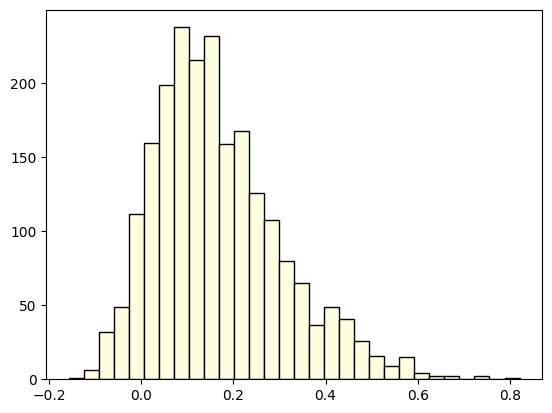

In [ ]:
plt.hist(sim_scores_neg, color='lightyellow', ec='black', bins=30)